<p style="violet"> Set up modules (standard and mine) </b>

In [65]:
### Import Standard Packages ###
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import metpy.calc as mpc
import metpy.constants as mconst
import xarray as xr
import scipy as spy
import pandas as pd
import datetime as dt
import cartopy

#dir(mconst)
### My Functions ###
import scam_func as mypy
import importlib

<b> Add Experiment Set </b>

In [66]:
#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######

#xr.show_versions()


## Multiple cases ##

#scam_file_nums = ['011a','011b','011c','011d']  # For comparisons
#scam_file_nums = ['012a','012b','012c','012d','012e','012f']  # For comparisons
#scam_file_nums = ['012a','012b','012f']
#scam_run_names = ['q_ft','0.5LS.T','no LS.Tq']

#scam_run_names = ['q_ft','0.5LS.T','0.5LS.q','0.5LS.Tq','0.25LS.Tq','no LS.Tq']

## Vertical resolution ##
#scam_file_nums = ['100a','100','100b','100c']
#scam_file_nums = ['101a','101','101b','101c','101d'] # 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['102a','102','102b','102c'] # 'a'=L15, ''=L30
#scam_run_names = ['L15','L30','L60','L120']


#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6','CAM5']


#scam_file_nums = ['101def','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 default','CAM5 default']

#scam_file_nums = ['101','101def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM6']

#scam_file_nums = ['102','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM5 2 min','CAM5']

#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM5 2 min']

#scam_file_nums = ['101d','101dx'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 until 4pm','CAM6 until 11:30pm']

#scam_file_nums = ['101d','201d','202d'] # 'a'=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

### WITH LES ###

#scam_file_nums = np.array(['101d','203d','204d','LES']) # 'a'=L16, ''=L32
#scam_run_names = ['clubb_c_k10=0.5','clubb_c_k10=0.3','clubb_c_k10','LES']

#scam_file_nums = ['101a','101','101b','101c','101d']# 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

scam_file_nums = ['106','106d'] # ''=L16, ''=L32
scam_run_names = ['CAM6-L32','CAM6-L256']

#scam_file_nums = ['106a','106','106b','106c','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L16','CAM6-L32','CAM6-L64','CAM6-L128','CAM6-256','NCAR']

#scam_file_nums = ['105d','LES','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6','CAM6->LES','NCAR']




scam_file_pre = "FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-39600"

#scam_files_in = [scam_file_pre+x+scam_file_suf for x in scam_file_nums]
#scam_files_in = np.where()

#print(scam_files_in)
#scam_file_suf = ".cam.h0.2013-06-10-43200"

# LES model selections.

les_files_in = {}
les_files_in['NCAR'] = "patton_sas_stats.nc"


### Construct filenames ### 

scam_files_in = np.empty_like(scam_file_nums)
scam_file_nums = np.array(scam_file_nums) 
scam_run_names = np.array(scam_run_names) 


# Standard SCAM
scam_files_in = ['history/'+scam_file_pre+x+scam_file_suf+'.nc' for x in scam_file_nums] 

# SCAM in SAS-LES format
ii = [ix for ix, x in enumerate(scam_file_nums) if x == 'LES']# Change to LES-SAS-format file if needed 
for i in ii: scam_files_in[i] = 'history/'+scam_file_pre+scam_file_nums[0]+scam_file_suf+'_SAS_format.nc' 

# LES in SAS-LES format
scam_files_in = np.where(scam_run_names == 'NCAR','LES/'+les_files_in['NCAR'],scam_files_in) # Change to LES file if needed
#scam_files_in = np.where(scam_run_names == 'FAST_EDDY','LES/'+les_files_in['FAST_EDDY'],scam_files_in) # Change to LES file if needed



print(scam_files_in)

#les_file_in = "LES/FSCAM.T42_T42.SAS.LES.cam.h0.2013-06-10-39600_SAS_format.nc"


['history/FSCAM.T42_T42.SAS.106.cam.h0.2013-06-10-39600.nc'
 'history/FSCAM.T42_T42.SAS.106d.cam.h0.2013-06-10-39600.nc']


<b> Diagnostic Field Selections </b>

In [67]:
#### PLOTTING ####

### 1D TS ### 

#pvars_ts1d = np.array(['PBLH','TS','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts1d = np.array(['PBL_DQMAX','PBLH_DQ','LHFLX','SHFLX'])



### 2D TS ###
                       ## WPSKEW is WP3_CLUBB/WP2_CLUBB**3/2
#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT', 
#            'STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','WP3_CLUBB','THLP2_CLUBB','WP2_CLUBB'] # 2D profile timeseries plots
#pvars_ts2d = ['WPRTP_CLUBB','Q','TH']
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts2d = ['TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB']




### 1D SNAPSHOT ###

#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']

#pvars_ts2d = ['STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB'] 
    
#pvars_snap = ['STEND_CLUBB','RVMTEND_CLUBB','TH','THL','Q','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']  # Snapshot plotting vars
#pvars_snap = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']
pvars_snap = ['TH','THL','Q','RELHUM','DTV','DCQ','STEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']

pvars_anim = np.array(('Q'))

tsnaps = np.array([6.,8.,10.,12.,14.,16])     # Time of snapshots (local time)


### Bundle these array for pasing to functions ###
run_info = {}
run_info['1dvars'] = pvars_ts1d
run_info['2dvars'] = pvars_ts2d
run_info['snapvars'] = pvars_snap

####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
#%matplotlib inline

<b> Files Setups </b>

In [90]:
#### CONSTANTS #####

r_gas = mconst.dry_air_gas_constant.magnitude   # Specific gas constant for dry air
cp_air = mconst.dry_air_spec_heat_press.magnitude # Specific heat for dry air
Lv = mconst.water_heat_vaporization.magnitude       # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = mconst.earth_gravity.magnitude       # Gravity ave.
p0 = mconst.pot_temp_ref_press.magnitude


####### DERIVED VARS #######



print('++++ Runs ++++')
print('')
#scam_files_in = scam_file_pre+scam_file_nums+scam_file_suf 
scam_fig_stub='png/'+'_'.join(scam_file_nums)

zoffset = 6.  # Offset for Z time.
### Bundle run info ###

run_info['Run Name']   = scam_run_names
run_info['File Num']   = scam_file_nums
run_info['File Name']  = scam_files_in
run_info['zoffset']    = zoffset
run_info['Stub Figs']  = scam_fig_stub
run_info['Snap Times']  = tsnaps

#df_rinfo = pd.DataFrame(rinfo)
#df_rinfo.style.set_properties(**{'background-color': 'white','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})



++++ Runs ++++



<b> Plot type selection </b>

+++ IMPORTING MY FUNCTIONS +++
------ SNAPSHOTS ------>>>   TH
------ CASE ------>>>   CAM6-L32  --  106  --  TH  ---  Potential Temperature  -- min/max -->  79.50759178099149 82.0521227063063
------ CASE ------>>>   CAM6-L256  --  106d  --  TH  ---  Potential Temperature  -- min/max -->  79.47912676013817 82.36211783055097
106d   101c   TH   THL
------ SNAPSHOTS ------>>>   THL
------ CASE ------>>>   CAM6-L32  --  106  --  THL  ---  Liq. Water Potential Temperature  -- min/max -->  71.5130618675955 81.948344330349
------ CASE ------>>>   CAM6-L256  --  106d  --  THL  ---  Liq. Water Potential Temperature  -- min/max -->  71.49948743679953 82.31714515722172
106d   101c   THL   THL
------ SNAPSHOTS ------>>>   Q
------ CASE ------>>>   CAM6-L32  --  106  --  Q  ---  Specific humidity  -- min/max -->  0.00013863303 0.011835558
------ CASE ------>>>   CAM6-L256  --  106d  --  Q  ---  Specific humidity  -- min/max -->  5.9223366e-05 0.011813239
106d   101c   Q   THL
------ SNAPSHOTS -----

ValueError: dimensions or multi-index levels ['lev'] do not exist

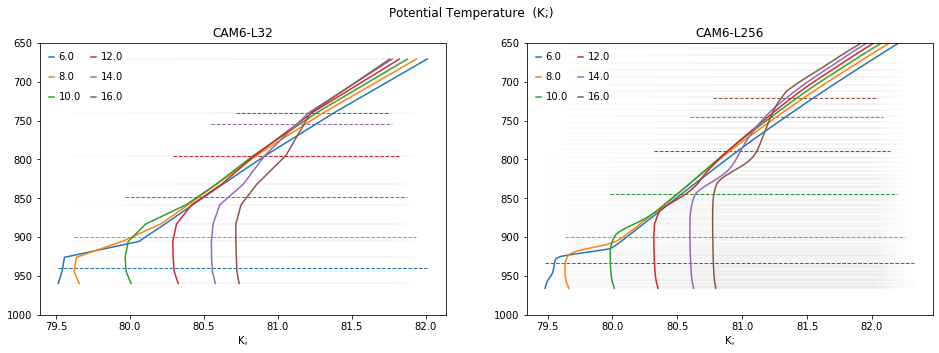

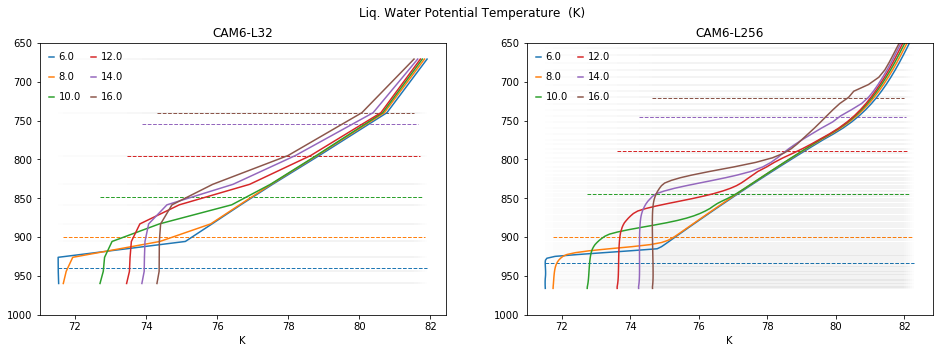

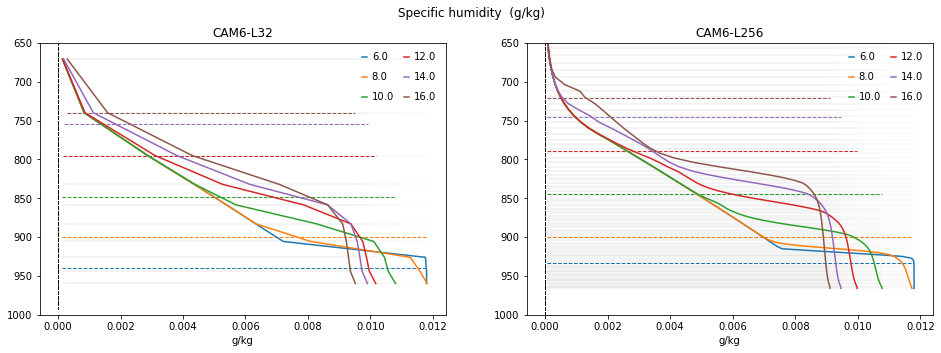

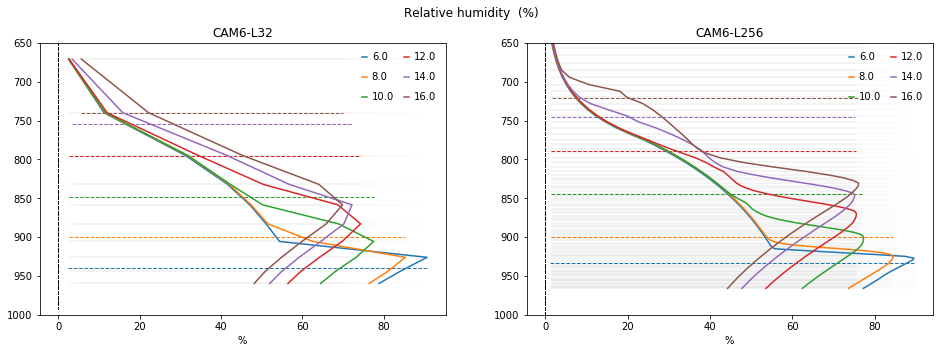

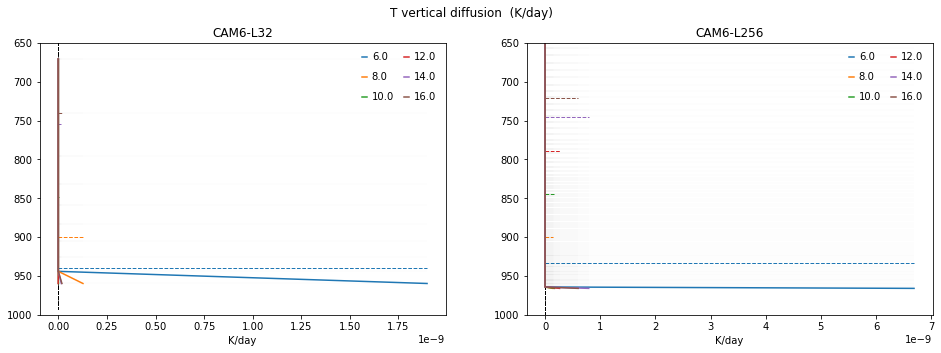

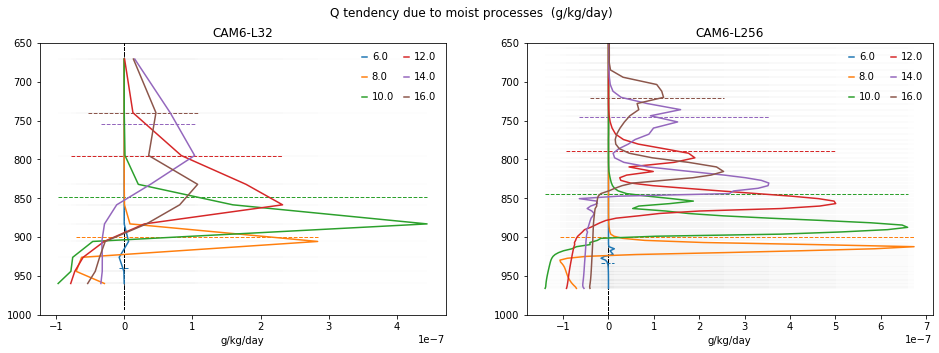

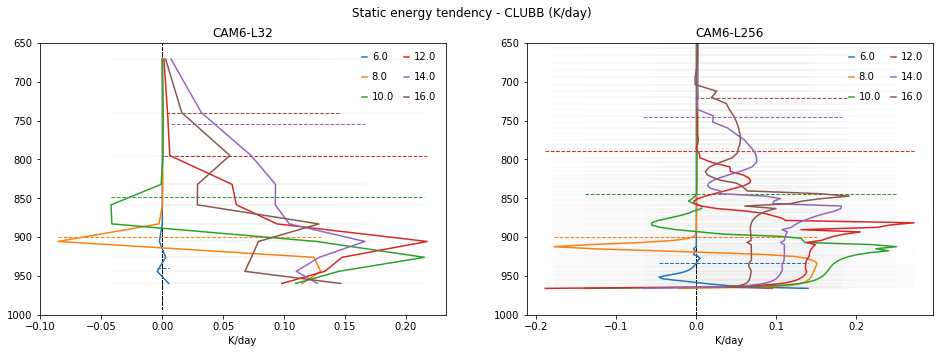

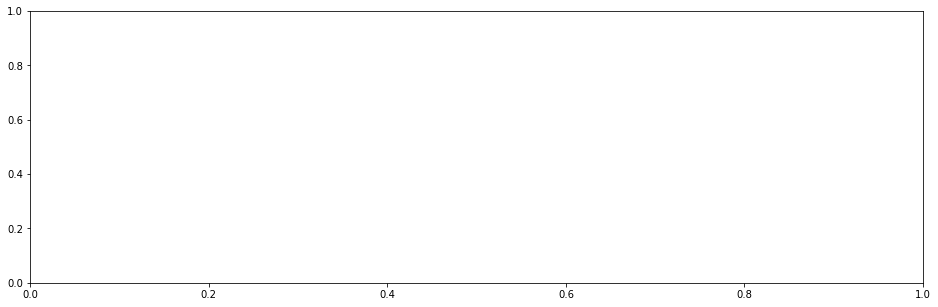

In [92]:
###### Plotting ##########
importlib.reload(mypy) # Required because I am constantly editing scam_func.py
#dir(mypy)

###### PLOTS ######

#mypy.plot1d_ts_scam(run_info)   # 1D time series plots
#mypy.plot2d_ts_scam(run_info)   # 2D time series plots
mypy.plot1d_snap_scam(run_info)   # 1D snapshot plots
#mypy.plot1d_anim_scam(run_info) # 2D animation  plots
